In [2]:
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as pp
import numpy as np

from sigma_graph.envs.figure8.action_lookup import MOVE_LOOKUP, TURN_90_LOOKUP
from sigma_graph.envs.figure8.default_setup import OBS_TOKEN
from sigma_graph.envs.figure8.figure8_squad_rllib import Figure8SquadRLLib
from sigma_graph.envs.figure8.gflow_figure8_squad import GlowFigure8Squad
#from graph_scout.envs.base import ScoutMissionStdRLLib
import sigma_graph.envs.figure8.default_setup as default_setup
from sigma_graph.data.file_manager import check_dir, find_file_in_dir, load_graph_files
import model  # THIS NEEDS TO BE HERE IN ORDER TO RUN __init__.py!
import model.utils as utils
import model.gnn_gflow 
from trajectory import Trajectory
import losses

import torch.optim as optim
import wandb
import json
import random
import networkx as nx
import matplotlib.pyplot as plt

NUM_EPOCHS = 100000
TRAJECTORY_LENGTH = 34
BATCH_SIZE = 100
LEARNING_RATE = 3e-4
WANDB = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

local_action_move = {
    0: "NOOP",
    1: "N",
    2: "S",
    3: "W",
    4: "E",
}

def state_to_vec(state):
    result = [0]*27
    result[state-1] = 1
    return torch.tensor(result).float()

def compute_reward(state):
    if state == 10:
        return 2
    if state == 2:
        return 1
    return 0

def convert_discrete_action_to_multidiscrete(action):
        return [action % len(local_action_move), action // len(local_action_move)]

In [3]:
# Investigate loss rewar mirror
# Try real reward
# Make code cleaner 
# visualize flows 

config = {
    "custom_model_config": {
        "custom_model": "attn_fcn", #fcn #attn_fcn
        "reward": "complex", #random_region random single complex
        "reward_interval": "step", #trajectory 
        "trajectory_per_reward": 1,
        "embedding": "coordinate", #number #coordinate
        "is_dynamic_embedding": True,
        "nred": 1,
        "nblue": 1,
        "start_node": 21,
        "aggregation_fn": "agent_node",
        "hidden_size": 15,
        "is_hybrid": False,
        "conv_type": "gcn",
        "layernorm": False,
        "graph_obs_token": {"embed_opt": False, "embed_dir": True},
    },
    "env_config": {
        "env_path": ".",
        "act_masked": True,
        "init_red": None,
        "init_blue": None,
        "init_health_red": 20,
        "init_health_blue": 20,
        "obs_embed": False,
        "obs_dir": False,
        "obs_team": True,
        "obs_sight": False,
        "log_on": True,
        "log_path": "logs/temp/",
        "fixed_start": -1,
        "penalty_stay": 0,
        "threshold_damage_2_blue": 2,
        "threshold_damage_2_red": 5,
    },
}

current_time = datetime.now()
run_name = f"{config['custom_model_config']['custom_model']}-{config['custom_model_config']['reward']}-{config['custom_model_config']['embedding']}-{current_time.strftime('%Y-%m-%d %H:%M:%S')}"
print(run_name)

if WANDB:
    wandb.init(
        project="graph-training-simulation",
        config={
                "model_config": config,
                "exp_config": {
                    "learning_rate": LEARNING_RATE,
                    "epocs": NUM_EPOCHS,
                    "batch_size": BATCH_SIZE
            }
        },
        name=run_name
    )

gflowfigure8 = GlowFigure8Squad(sampler_config=config)
optimizer = optim.AdamW(gflowfigure8.sampler.parameters(), lr=LEARNING_RATE)

attn_fcn-single-coordinate-2024-04-18 00:09:27
---------------
path_data ./GflowsForSimulation/sigma_graph/data/parsed/
/home/rmarr/Documents/GflowsForSimulation_env/GflowsForSimulation
data_pat /home/rmarr/Documents/GflowsForSimulation_env/GflowsForSimulation/sigma_graph/data/parsed/info_list_pat_0_27.pickle


In [4]:
torch.autograd.set_detect_anomaly(True)

minibatch_loss = 0
minibatch_reward = 0
minibatch_z = 0
minibatch_pf = 0
minibatch_pb = 0

pbar = tqdm(total=NUM_EPOCHS)
episode = 0

while episode <= NUM_EPOCHS:
  
  TEMP_AGENT_INDEX = 0
  gflowfigure8._reset_agents()
  
  total_P_F = 0
  total_P_B = 0
  total_reward = 0

  region_nodes = {15, 11, 10}

  if config['custom_model_config']['reward'] == 'random':
    reward_node = [random.randint(1, 27)]
  elif config['custom_model_config']['reward'] == 'random_region':
    reward_node = random.sample(region_nodes, 1)
  elif config['custom_model_config']['reward'] == 'single':
    reward_node = [13]
  elif config['custom_model_config']['reward'] == 'complex':
    reward_node = []
  
  gflowfigure8.update_reward(reward_node)
  no_trajectory = config['custom_model_config']['trajectory_per_reward']

  for trajectory in range(no_trajectory):
    trajectory_path = []
    action_path = []
    for t in range(TRAJECTORY_LENGTH):
      step = gflowfigure8.step(TEMP_AGENT_INDEX, reward_node)  
      total_P_F += step['forward_prob']
      total_P_B += step['backward_prob']
      total_reward += step['step_reward']
      trajectory_path.append(step['node'])
      action_path.append(step['action'])

    logZ = gflowfigure8.sampler.logZ
    # TODO find more elegant solution to nan issue
    total_reward += gflowfigure8._episode_rewards()[0]
    clipped_reward = torch.log(torch.tensor(total_reward+100)).clip(-20)
    loss = (logZ + total_P_F - clipped_reward - total_P_B).pow(2)

    minibatch_loss += loss
    minibatch_reward += clipped_reward
    minibatch_z += logZ
    minibatch_pf += total_P_F
    minibatch_pb += total_P_B

    if (episode + 1) % BATCH_SIZE == 0:
      if WANDB:
        wandb.log({
            "loss": minibatch_loss/BATCH_SIZE, 
            "reward":  minibatch_reward/BATCH_SIZE,
            "pf": minibatch_pf/BATCH_SIZE,
            "pb": minibatch_pb/BATCH_SIZE,
            "z": minibatch_z/BATCH_SIZE
          })
        # for name, param in sampler.named_parameters():
        #     wandb.log({f"{name}_mean": param.data.mean().item(), f"{name}_std": param.data.std().item()})
      
      minibatch_loss.backward(retain_graph=True)
      optimizer.step()
      optimizer.zero_grad()
      minibatch_loss = 0
      minibatch_reward = 0
      minibatch_z = 0 
      minibatch_pf = 0 
      minibatch_pb = 0 

    pbar.update(1)
    episode = episode + 1

  0%|          | 42/100000 [00:24<15:51:07,  1.75it/s]

In [ ]:
torch.save(gflowfigure8, f'{run_name}.pt')

In [ ]:
gflowfigure8 = torch.load('attn_fcn-complex-coordinate-2024-04-17 11:54:53.pt')

flows {0: {'NOOP': 0.20470529789615585, 'N': 0.0, 'S': 0.516639568070979, 'W': 0.2088542715882715, 'E': 0.0698008624445936}, 1: {'NOOP': 0.22202073045002266, 'N': 0.0, 'S': 0.5166621891910953, 'W': 0.18668813880132987, 'E': 0.07462894155755215}, 2: {'NOOP': 0.22202073045002266, 'N': 0.0, 'S': 0.5166621891910953, 'W': 0.18668813880132987, 'E': 0.07462894155755215}, 3: {'NOOP': 0.22202073045002266, 'N': 0.0, 'S': 0.5166621891910953, 'W': 0.18668813880132987, 'E': 0.07462894155755215}, 4: {'NOOP': 0.22202073045002266, 'N': 0.0, 'S': 0.5166621891910953, 'W': 0.18668813880132987, 'E': 0.07462894155755215}, 5: {'NOOP': 0.22202073045002266, 'N': 0.0, 'S': 0.5166621891910953, 'W': 0.18668813880132987, 'E': 0.07462894155755215}, 6: {'NOOP': 0.22202073045002266, 'N': 0.0, 'S': 0.5166621891910953, 'W': 0.18668813880132987, 'E': 0.07462894155755215}, 7: {'NOOP': 0.22202073045002266, 'N': 0.0, 'S': 0.5166621891910953, 'W': 0.18668813880132987, 'E': 0.07462894155755215}, 8: {'NOOP': 0.22202073045002

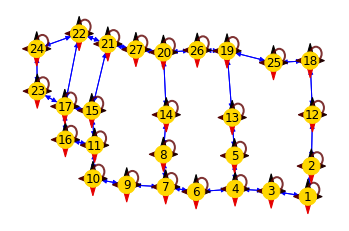

In [ ]:
# TODO: there has to be a better way to do this
def norm_dict(unnorm):
    min_val = 9999999
    for key in unnorm:
        min_val = min(unnorm[key], min_val)
    for key in unnorm:
        unnorm[key] = unnorm[key] + (min(min_val, 0) * -1)
    sum = 0
    for key in unnorm:
        sum += unnorm[key]
    for key in unnorm:
        unnorm[key] /= sum
        
gflowfigure8._reset_agents()
state_dirs = {}
for node in range(27):
    states = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
    states[0][node] = 1
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    state = torch.tensor(np.array([states[0],], dtype=np.int8)).to(device)
    probs = gflowfigure8.sampler.forward(state, [1])
    # (forward_prob, action) = gflowfigure8.probs_to_action(probs)
    total_probs = {}
    total_probs["NOOP"] = (probs[0]+probs[5]+probs[10]).tolist()
    total_probs["N"] = (probs[1]+probs[6]+probs[11]).tolist()
    total_probs["S"] = (probs[2]+probs[7]+probs[12]).tolist()
    total_probs["W"] = (probs[3]+probs[8]+probs[13]).tolist()
    total_probs["E"] = (probs[4]+probs[9]+probs[14]).tolist()
    norm_dict(total_probs)

    state_dirs[node] = total_probs

flows = state_dirs
print(f'flows {flows}')
map_info, _ = load_graph_files(map_lookup="S")

fig = plt.figure()
fig.patch.set_alpha(0.)
fig.tight_layout()

plt.axis('off')

col_map = ["gold"] * len(map_info.n_info)

nx.draw_networkx(map_info.g_acs, map_info.n_info, node_color=col_map, edge_color="blue", arrows=True)

max_x = max(pos[0] for pos in map_info.n_info.values())
max_y = max(pos[1] for pos in map_info.n_info.values())
scale_factor = max(max_x, max_y) / 2000
op_to_dir = {
    'N': (0, 1), 
    'S': (0, -1), 
    'W': (-1, 0),
    'E': (1, 0)
}
for node in map_info.g_acs.nodes:
    pos = map_info.n_info[node]
    x, y = pos
    dir_flows = flows[node-1]

    color_vals = np.linspace(0, 1.75, 100)
    colors = [(color, 0, 0, 0) for color in color_vals]

    for op in ['N', 'S', 'W', 'E']:
        flow = int((dir_flows[op]) * 99)
        dx, dy = op_to_dir[op]
        plt.arrow(x, y, dx*scale_factor, dy*scale_factor, color=colors[flow], alpha=1, width=0.1, head_width=1)

    circle_radius = 1.00 
    circle_center_x = x + circle_radius  
    circle_center_y = y + circle_radius 

    flow = int((dir_flows['NOOP']) * 99)

    circle = plt.Circle((circle_center_x, circle_center_y), circle_radius, color=colors[flow], alpha=0.8, fill=False, linewidth=2)

    plt.gca().add_patch(circle)


#plt.close()

In [ ]:
print(flows[11])
print(flows[10])
print(flows[12])

{'NOOP': 0.1496805983790266, 'N': 0.24280015666327923, 'S': 0.1580351943342287, 'W': 0.4494840506234654, 'E': 0.0}
{'NOOP': 0.1496805983790266, 'N': 0.24280015666327923, 'S': 0.1580351943342287, 'W': 0.4494840506234654, 'E': 0.0}
{'NOOP': 0.1496805983790266, 'N': 0.24280015666327923, 'S': 0.1580351943342287, 'W': 0.4494840506234654, 'E': 0.0}


In [ ]:
trajectory = Trajectory()
gflowfigure8._reset_agents()
for _ in range(20):   
    for a_id in range(1):
        step = gflowfigure8.step(a_id, [])
        trajectory.add_step(
            forward_prob=step['forward_prob'],
            backward_prob=step['backward_prob'],
            # flow=step['flow'],
            # action=step['action'],
            reward=step['step_reward'],
            # node=step['node']
        )
        print(step['node'])
        #print(step['action'])

AttributeError: 'SamplerAttnFCN' object has no attribute 'dynamic_embedding'

{'00_0000': 1, '01_0011': 2, '00_0001': 3, '00_0010': 4, '01_0100': 5, '00_0011': 6, '00_0100': 7, '01_0101': 8, '00_0101': 9, '00_0110': 10, '01_0110': 11, '10_0011': 12, '10_0100': 13, '10_0101': 14, '10_0110': 15, '01_0111': 16, '10_0111': 17, '11_0011': 18, '11_0101': 19, '11_0111': 20, '11_1001': 21, '11_1010': 22, '10_1000': 23, '11_1011': 24, '11_0100': 25, '11_0110': 26, '11_1000': 27}
{1: (362.0, 1966.8), 3: (355.6, 1967.6), 4: (349.3, 1967.9), 6: (342.5, 1967.5), 7: (337.2, 1968.2), 9: (330.4, 1968.5), 10: (324.5, 1969.4), 2: (362.6, 1971.2), 5: (349.2, 1972.7), 8: (336.8, 1972.9), 11: (324.8, 1974.2), 16: (319.7, 1975.0), 12: (362.8, 1978.6), 13: (348.8, 1978.2), 14: (337.3, 1978.6), 15: (324.3, 1979.2), 17: (319.6, 1979.8), 23: (314.8, 1982.0), 18: (362.4, 1986.4), 25: (356.0, 1986.1), 19: (347.9, 1987.8), 26: (342.7, 1987.9), 20: (336.8, 1987.6), 27: (332.0, 1988.0), 21: (327.1, 1988.8), 22: (322.1, 1990.3), 24: (314.7, 1988.1)}
['11_1010', '11_1001', '11_1000', '11_0111',

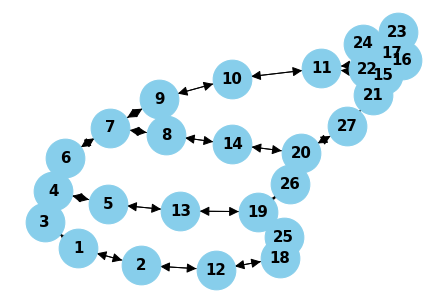

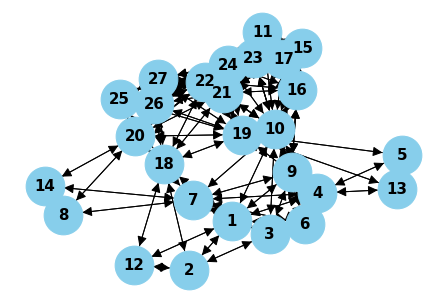

In [ ]:
import os
import pickle
import networkx as nx
import matplotlib.pyplot as plt

path_data = '/home/rmarr/Documents/GflowsForSimulation_env/GflowsForSimulation/sigma_graph/data/parsed'

with open(f'{path_data}/graph_acs_27.pickle', 'rb') as f:
    graph_acs_27 = pickle.load(f)
plt.figure(figsize=(6, 4))
nx.draw(graph_acs_27, with_labels=True, node_color='skyblue', node_size=1500, arrowsize=20, font_size=15, font_weight='bold')

with open(f'{path_data}/graph_vis_27.pickle', 'rb') as f:
    graph_vis_27 = pickle.load(f)
plt.figure(figsize=(6, 4))
nx.draw(graph_vis_27, with_labels=True, node_color='skyblue', node_size=1500, arrowsize=20, font_size=15, font_weight='bold')

with open(f'{path_data}/info_dict_emb_27.pickle', 'rb') as f:
    info_dict_emb_27 = pickle.load(f)
    print(info_dict_emb_27)

with open(f'{path_data}/info_dict_pos_27.pickle', 'rb') as f:
    info_dict_pos_27 = pickle.load(f)
    print(info_dict_pos_27)

with open(f'{path_data}/info_list_pat_1_27.pickle', 'rb') as f:
    info_list_pat_1_27 = pickle.load(f)
    print(info_list_pat_1_27)

{'00_0000': 1, '01_0011': 2, '00_0001': 3, '00_0010': 4, '01_0100': 5, '00_0011': 6, '00_0100': 7, '01_0101': 8, '00_0101': 9, '00_0110': 10, '01_0110': 11, '10_0011': 12, '10_0100': 13, '10_0101': 14, '10_0110': 15}
{1: (362.0, 1966.8), 3: (355.6, 1967.6), 4: (349.3, 1967.9), 6: (342.5, 1967.5), 7: (337.2, 1968.2), 9: (330.4, 1968.5), 10: (324.5, 1969.4), 2: (362.6, 1971.2), 5: (349.2, 1972.7), 8: (336.8, 1972.9), 11: (324.8, 1974.2), 12: (362.8, 1978.6), 13: (348.8, 1978.2), 14: (337.3, 1978.6), 15: (324.3, 1979.2)}
['00_0000', '01_0011', '10_0011', '01_0011', '00_0000', '00_0001', '00_0010', '01_0100', '10_0100', '01_0100', '00_0010', '00_0011', '00_0100', '01_0101', '10_0101', '01_0101', '00_0100', '00_0101', '00_0110', '01_0110', '10_0110', '01_0110', '00_0110', '00_0101', '00_0100', '00_0011', '00_0010', '00_0001']


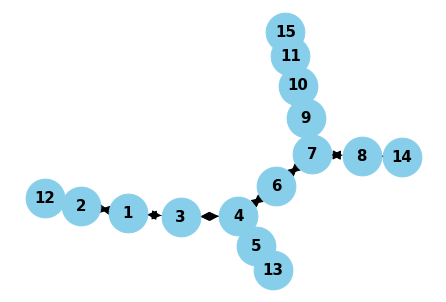

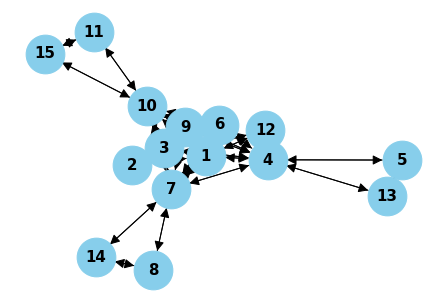

In [ ]:
nodes_to_delete = list(range(16, 28))
for node in nodes_to_delete:
    graph_acs_27.remove_node(node)
    graph_vis_27.remove_node(node)
plt.figure(figsize=(6, 4))
nx.draw(graph_acs_27, with_labels=True, node_color='skyblue', node_size=1500, arrowsize=20, font_size=15, font_weight='bold')
plt.figure(figsize=(6, 4))
nx.draw(graph_vis_27, with_labels=True, node_color='skyblue', node_size=1500, arrowsize=20, font_size=15, font_weight='bold')
with open(f'{path_data}/graph_acs_15.pickle', 'wb') as f:
    pickle.dump(graph_acs_27, f)
with open(f'{path_data}/graph_vis_15.pickle', 'wb') as f:
    pickle.dump(graph_vis_27, f)

info_dict_emb_15 = dict()
for key in info_dict_emb_27:
    if not info_dict_emb_27[key] in nodes_to_delete:
        info_dict_emb_15[key] = info_dict_emb_27[key]
print(info_dict_emb_15)
with open(f'{path_data}/info_dict_emb_15.pickle', 'wb') as f:
    pickle.dump(info_dict_emb_15, f)

info_dict_pos_15 = dict()
for key in info_dict_pos_27:
    if not key in nodes_to_delete:
        info_dict_pos_15[key] = info_dict_pos_27[key]
print(info_dict_pos_15)
with open(f'{path_data}/info_dict_pos_15.pickle', 'wb') as f:
    pickle.dump(info_dict_pos_15, f)

node_to_code = dict()
for k in info_dict_emb_15:
    node_to_code[info_dict_emb_15[k]] = k
node_path = [1,2,12,2,1,3,4,5,13,5,4,6,7,8,14,8,7,9,10,11,15,11,10,9,7,6,4,3]
code_path = []
for node in node_path:
    code_path.append(node_to_code[node])
print(code_path)
with open(f'{path_data}/info_list_pat_0_15.pickle', 'wb') as f:
    pickle.dump(code_path, f)